# **Part 01: Apprentissage avec des Benchmarks**

## **1. Préparation et exploration des données**

In [36]:
# Téléchargement des données qui sont dans le répertoire datasets 
from prepdata import data_recovery

datasets = [
    "abalone8", "abalone17", "abalone20",
    "autompg", "australian", "balance", "bankmarketing",
    "bupa", "german", "glass", "hayes", "heart", "iono",
    "libras", "newthyroid", "pageblocks", "pima",
    "satimage", "segmentation", "sonar", "spambase",
    "splice", "vehicle", "wdbc", "wine", "wine4",
    "yeast3", "yeast6",
]

for name in datasets:
    X, y = data_recovery(name)
    print(name, X.shape, y.shape)


abalone8 (4177, 10) (4177,)
abalone17 (4177, 10) (4177,)
abalone20 (4177, 10) (4177,)
autompg (392, 7) (392,)
australian (690, 14) (690,)
balance (625, 4) (625,)
bankmarketing (45211, 51) (45211,)
bupa (345, 6) (345,)
german (1000, 24) (1000,)
glass (214, 9) (214,)
hayes (132, 4) (132,)
heart (270, 13) (270,)
iono (351, 34) (351,)
libras (360, 90) (360,)
newthyroid (215, 5) (215,)
pageblocks (5473, 10) (5473,)
pima (768, 8) (768,)
satimage (6435, 36) (6435,)
segmentation (2310, 19) (2310,)
sonar (208, 60) (208,)
spambase (4597, 57) (4597,)
splice (3175, 60) (3175,)
vehicle (846, 18) (846,)
wdbc (569, 30) (569,)
wine (178, 13) (178,)
wine4 (1599, 11) (1599,)
yeast3 (1484, 8) (1484,)
yeast6 (1484, 8) (1484,)


In [37]:
# Construction d'une table récapitulative des informations sur les datasets
import numpy as np
import pandas as pd
from prepdata import data_recovery

datasets = [
    "abalone8", "abalone17", "abalone20",
    "autompg", "australian", "balance", "bankmarketing",
    "bupa", "german", "glass", "hayes", "heart", "iono",
    "libras", "newthyroid", "pageblocks", "pima",
    "satimage", "segmentation", "sonar", "spambase",
    "splice", "vehicle", "wdbc", "wine", "wine4",
    "yeast3", "yeast6",
]

info_rows = []
imbalanced_datasets = []   # pour stocker les jeux déséquilibrés

threshold = 0.2           # classe minoritaire < 20% => déséquilibré

for name in datasets:
    X, y = data_recovery(name)

    n, d = X.shape
    ratio_positive = np.mean(y == 1)
    ratio_negative = np.mean(y == 0)

    # minoritaire = min(ratio_pos, ratio_neg)
    minority_ratio = min(ratio_positive, ratio_negative)


    # détection valeurs manquantes
    n_missing = np.isnan(X).sum()
    has_missing = n_missing > 0

    info_rows.append({
        "dataset": name,
        "n_samples": n,
        "n_features": d,
        "ratio_positive": ratio_positive,
        "ratio_negative": ratio_negative,
        "minority_ratio": minority_ratio,
        "imbalanced": minority_ratio < threshold,  
        "has_missing": has_missing,
        "n_missing": int(n_missing),
        "problem_type": "binary_classification",
    })

    # si dataset déséquilibré, on l'ajoute à une liste spéciale
    if minority_ratio < threshold:
        imbalanced_datasets.append(name)

info_df = pd.DataFrame(info_rows)
print(info_df)
#info_df.to_csv("dataset_info_summary.csv", index=False)

# Affichage des datasets déséquilibrés
print("\nDatasets déséquilibrés (< 30% de la classe minoritaire) :")
print(imbalanced_datasets)
print("Nombre de datasets déséquilibrés :", len(imbalanced_datasets))

#Nombre de datasets qui contiennent des valeurs manquantes
n_datasets_with_missing = info_df["has_missing"].sum()
print("Nombre de datasets avec des valeurs manquantes :", n_datasets_with_missing)



          dataset  n_samples  n_features  ratio_positive  ratio_negative  \
0        abalone8       4177          10        0.135983        0.864017   
1       abalone17       4177          10        0.013886        0.986114   
2       abalone20       4177          10        0.006225        0.993775   
3         autompg        392           7        0.375000        0.625000   
4      australian        690          14        0.444928        0.555072   
5         balance        625           4        0.460800        0.539200   
6   bankmarketing      45211          51        0.116985        0.883015   
7            bupa        345           6        0.420290        0.579710   
8          german       1000          24        0.300000        0.700000   
9           glass        214           9        0.327103        0.672897   
10          hayes        132           4        0.227273        0.772727   
11          heart        270          13        0.444444        0.555556   
12          

## **2. Protocole commun**

In [38]:
# Le but est de définir une fonction générique avec un split train/test, les métriques et la mesure du temps d’apprentissage. On va l'utiliser par la suite pour tous les datasets.
import numpy as np
from time import perf_counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

def evaluate_model(
    model,
    X,
    y,
    test_size=0.3,
    n_iter=5,
    random_state=0,
):
    """
    model : estimateur sklearn déjà configuré 
    X, y : données complètes
    Retourne un dict avec moyennes (accuracy, f1, auc, temps d'apprentissage)
    sur n_iter splits aléatoires + écart-type pour F1.
    """
    accuracies = []
    f1_scores = []
    aucs = []
    train_times = []
    n_train = []
    n_test = []

    # pour reproduire mais avoir des splits différents
    rng = np.random.RandomState(random_state)

    for i in range(n_iter):
        rs = rng.randint(0, 10_000_000)

        X_train, X_test, y_train, y_test = train_test_split(
            X,
            y,
            test_size=test_size,
            stratify=y,
            random_state=rs,
        )

        t0 = perf_counter()
        model.fit(X_train, y_train)
        t1 = perf_counter()
        train_time = t1 - t0

        y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        try:
            if hasattr(model, "predict_proba"):
                y_scores = model.predict_proba(X_test)[:, 1]
            else:
                y_scores = model.decision_function(X_test)
            auc = roc_auc_score(y_test, y_scores)
        except Exception:
            auc = np.nan

        accuracies.append(acc)
        f1_scores.append(f1)
        aucs.append(auc)
        train_times.append(train_time)
        n_train.append(len(y_train))
        n_test.append(len(y_test))

    return {
        "accuracy": float(np.mean(accuracies)),
        "f1": float(np.mean(f1_scores)),
        "f1_std": float(np.std(f1_scores, ddof=1)),  
        "auc": float(np.nanmean(aucs)),
        "train_time": float(np.mean(train_times)),
        "n_train": int(np.mean(n_train)),
        "n_test": int(np.mean(n_test)),
        "n_iter": n_iter,
    }


In [39]:
# Construction d'une table de résultats finale à partir d'un DataFrame de résultats de chaque famille de modèles
import pandas as pd

def build_results_table(results_df):
    """
    results_df doit contenir :
      - dataset
      - imbalanced (bool)
      - model_name
      - f1 (numérique)
      - f1_std (numérique)
    Retourne un DataFrame avec :
      - une ligne par dataset
      - colonnes = modèles (F1 ± std)
      - best_method = meilleur modèle (F1 moyen)
    """
    df = results_df.copy()

    # Colonne texte F1 ± écart-type
    df["f1_display"] = df.apply(
        lambda row: f'{row["f1"]:.3f} ± {row["f1_std"]:.3f}',
        axis=1,
    )

    # Table large : lignes = datasets, colonnes = modèles, valeurs = F1 ± std
    table_wide = df.pivot_table(
        index=["dataset", "imbalanced"],
        columns="model_name",
        values="f1_display",
        aggfunc="first",
    )

    # Table numérique des F1 moyens pour trouver la meilleure méthode
    f1_mean_wide = df.pivot_table(
        index="dataset",
        columns="model_name",
        values="f1",
        aggfunc="mean",
    )
    best_method = f1_mean_wide.idxmax(axis=1)

    # Ajout de best_method et réordonnancement
    table_wide = table_wide.reset_index()
    table_wide["best_method"] = table_wide["dataset"].map(best_method)

    cols_order = (
        ["dataset", "imbalanced"] +
        [c for c in table_wide.columns if c not in ["dataset", "imbalanced", "best_method"]] +
        ["best_method"]
    )
    table_final = table_wide[cols_order]

    return table_final


In [40]:
# Affichage d'une heatmap des F1 moyens par dataset et par modèle, avec encadrement de la meilleure méthode
import matplotlib.pyplot as plt
import seaborn as sns

def plot_f1_heatmap(results_df, family_name="", normalize_rows=True):
    """
    results_df doit contenir :
      - dataset
      - model_name
      - f1
    Affiche une heatmap des F1 moyens :
      - lignes = datasets
      - colonnes = modèles
      - couleurs éventuellement normalisées par ligne
      - meilleure méthode par dataset encadrée
    """
    df = results_df.copy()

    # Matrice F1 moyen
    heatmap_data = df.pivot_table(
        index="dataset",
        columns="model_name",
        values="f1",
        aggfunc="mean",
    )

    # Normalisation par ligne (optionnelle)
    if normalize_rows:
        heatmap_norm = heatmap_data.div(heatmap_data.max(axis=1), axis=0)
    else:
        heatmap_norm = heatmap_data

    # Trouver la meilleure méthode par dataset
    best_cols = heatmap_data.idxmax(axis=1)

    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(
        heatmap_norm,
        annot=heatmap_data.round(3),  # on affiche les vrais F1
        fmt=".3f",
        cmap="magma_r",               # foncé = fort
    )

    # Encadrer la meilleure cellule de chaque ligne
    for i, (dataset, col_name) in enumerate(best_cols.items()):
        j = heatmap_data.columns.get_loc(col_name)
        ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='white', lw=2))

    title = "F1 des variantes par dataset"
    if family_name:
        title = f"F1 des variantes {family_name} par dataset"
    plt.title(title)
    plt.ylabel("Dataset")
    plt.xlabel("Modèle")
    plt.tight_layout()
    plt.show()


## **3. Approches non paramétriques**

In [41]:
# Sur cette partie, on va se concentrer sur le KNN avec ses différentes variantes.
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import GridSearchCV

#Définition des variantes KNN


# 1) KNN de base : k=5, distance euclidienne, poids uniformes 
knn_base = KNeighborsClassifier(
    n_neighbors=5,
    weights="uniform",
    metric="minkowski",
    p=2,
)

# 2) KNN pondéré par la distance : les voisins proches comptent plus 
knn_distance = KNeighborsClassifier(
    n_neighbors=5,
    weights="distance",
    metric="minkowski",
    p=2,
)

# 3) KNN avec normalisation des features : StandardScaler + KNN 
knn_scaled = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier(
        n_neighbors=5,
        weights="uniform",
        metric="minkowski",
        p=2,
    ),
)

# 4) KNN avec k optimisé par validation croisée (GridSearchCV)
#    On cherche le meilleur n_neighbors dans {1,3,5,7,11}
def make_knn_cv():
    """
    Crée un GridSearchCV neuf pour KNN :
    - pipeline StandardScaler + KNN
    - recherche de k via validation croisée
    """
    base_pipe = make_pipeline(
        StandardScaler(),
        KNeighborsClassifier(weights="uniform"),
    )
    param_grid = {
        "kneighborsclassifier__n_neighbors": [1, 3, 5, 7, 11],
    }
    grid = GridSearchCV(
        estimator=base_pipe,
        param_grid=param_grid,
        cv=5,
        scoring="f1",   # on optimise le F1-score 
        n_jobs=-1,
    )
    return grid

# 5) KNN avec SMOTE + normalisation (pour données déséquilibrées), méthode qu'on utilisera seulement si le dataset est déséquilibré, d'ou l'utilité de la colonne qu'on a rajouté dans le tableau récapitulatif
knn_smote = ImbPipeline(
    steps=[
        ("smote", SMOTE(random_state=0)),
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier(
            n_neighbors=5,
            weights="uniform",
            metric="minkowski",
            p=2,
        )),
    ]
)

# Dictionnaire pour le tableau benchmark
models_knn = {
    "knn_base": knn_base,
    "knn_distance": knn_distance,
    "knn_scaled": knn_scaled,
    "knn_cv": make_knn_cv,   
    "knn_smote": knn_smote,  
}


# Evaluation de toutes les variantes KNN

results_rows = []

for ds in datasets:   
    # vérifier si le dataset est déséquilibré
    row_info = info_df[info_df["dataset"] == ds].iloc[0]
    is_imbalanced = bool(row_info["imbalanced"])

    # charger X, y
    X, y = data_recovery(ds)

    for model_name, model_or_factory in models_knn.items():
        # on skippe knn_smote si le dataset est équilibré
        if (model_name == "knn_smote") and (not is_imbalanced):
            continue

    
        if callable(model_or_factory):
            model = model_or_factory()
        else:
            model = model_or_factory

        res = evaluate_model(model, X, y)
        res.update({
            "dataset": ds,
            "model_family": "knn",
            "model_name": model_name,
            "imbalanced": is_imbalanced,
        })
        results_rows.append(res)

results_knn_df = pd.DataFrame(results_rows)



In [ ]:
# Affichage d'un tableau avec lignes = datasets, colonnes = variantes KNN, valeur = accuracy
# on peut faire pareil oui pour f1, auc, train_time 
acc_table = results_knn_df.pivot_table(
    index="dataset",
    columns="model_name",
    values="accuracy"
)
print(acc_table)

model_name     knn_base    knn_cv  knn_distance  knn_scaled  knn_smote
dataset                                                               
abalone17      0.985486  0.976077      0.985486    0.986284   0.889314
abalone20      0.993620  0.986922      0.993620    0.993620   0.937959
abalone8       0.844498  0.798724      0.841946    0.841467   0.669059
australian     0.653140  0.843478      0.654106    0.839614        NaN
autompg        0.801695  0.808475      0.808475    0.823729        NaN
balance        0.906383  0.943617      0.906383    0.900000        NaN
bankmarketing  0.881937  0.877912      0.881171    0.893439   0.852389
bupa           0.657692  0.623077      0.653846    0.621154        NaN
german         0.701333  0.680667      0.702667    0.712667        NaN
glass          0.744615  0.756923      0.744615    0.769231        NaN
hayes          0.875000  0.885000      0.875000    0.865000   0.895000
heart          0.649383  0.809877      0.651852    0.804938        NaN
iono  

In [ ]:
# On compare avec F1, vu que l'accuracy n'est pas toujours le meilleur indicateur surtout sur les datasets déséquilibrés, elle est souvent trompeuse
f1_table = results_knn_df.pivot_table(
    index="dataset",
    columns="model_name",
    values="f1"
)
print(f1_table)

model_name     knn_base    knn_cv  knn_distance  knn_scaled  knn_smote
dataset                                                               
abalone17      0.000000  0.060332      0.021053    0.000000   0.070920
abalone20      0.000000  0.022222      0.000000    0.000000   0.068150
abalone8       0.190854  0.240619      0.184475    0.195764   0.324014
australian     0.568214  0.819366      0.578109    0.814692        NaN
autompg        0.750970  0.764944      0.760826    0.782198        NaN
balance        0.898731  0.938449      0.898731    0.891485        NaN
bankmarketing  0.347954  0.410072      0.354446    0.406844   0.464003
bupa           0.559847  0.550305      0.557130    0.545103        NaN
german         0.400207  0.432711      0.403980    0.422621        NaN
glass          0.621483  0.660288      0.626195    0.687667        NaN
hayes          0.583077  0.652745      0.583077    0.548791   0.765556
heart          0.561946  0.782886      0.567826    0.775715        NaN
iono  

In [ ]:
# Pareil pour l'AUC 
auc_table = results_knn_df.pivot_table(
    index="dataset",
    columns="model_name",
    values="auc"
)
print(auc_table)

model_name     knn_base    knn_cv  knn_distance  knn_scaled  knn_smote
dataset                                                               
abalone17      0.566836  0.553569      0.567550    0.565433   0.702054
abalone20      0.489968  0.495987      0.489968    0.547151   0.596810
abalone8       0.679764  0.582487      0.676948    0.671769   0.711253
australian     0.710208  0.910491      0.700000    0.898015        NaN
autompg        0.846898  0.847666      0.862869    0.867322        NaN
balance        0.972801  0.983328      0.973939    0.967680        NaN
bankmarketing  0.766091  0.671589      0.765568    0.797585   0.793856
bupa           0.712689  0.586364      0.717424    0.664583        NaN
german         0.611217  0.619841      0.620794    0.677910        NaN
glass          0.833333  0.825216      0.849567    0.771104        NaN
hayes          0.976703  0.973118      0.978495    0.973118   0.913978
heart          0.726235  0.908333      0.720988    0.847531        NaN
iono  

In [45]:
# Affichage de la table finale des résultats KNN avec F1 ± écart-type et meilleure méthode 
table_final_knn = build_results_table(results_knn_df)
print(table_final_knn.head())

model_name     dataset  imbalanced       knn_base         knn_cv  \
0            abalone17        True  0.000 ± 0.000  0.060 ± 0.043   
1            abalone20        True  0.000 ± 0.000  0.022 ± 0.050   
2             abalone8        True  0.191 ± 0.029  0.241 ± 0.024   
3           australian       False  0.568 ± 0.029  0.819 ± 0.023   
4              autompg       False  0.751 ± 0.061  0.765 ± 0.031   

model_name   knn_distance     knn_scaled      knn_smote best_method  
0           0.021 ± 0.047  0.000 ± 0.000  0.071 ± 0.031   knn_smote  
1           0.000 ± 0.000  0.000 ± 0.000  0.068 ± 0.025   knn_smote  
2           0.184 ± 0.027  0.196 ± 0.023  0.324 ± 0.023   knn_smote  
3           0.578 ± 0.016  0.815 ± 0.027            NaN      knn_cv  
4           0.761 ± 0.059  0.782 ± 0.052            NaN  knn_scaled  


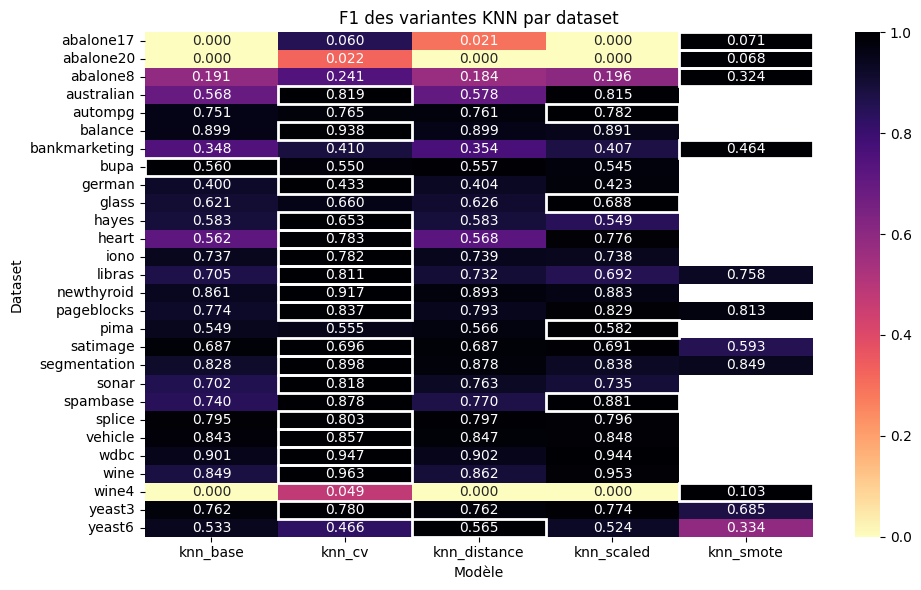

In [43]:
# Affichage de la heatmap des F1 moyens par dataset et par variante KNN, avec encadrement de la meilleure méthode
plot_f1_heatmap(results_knn_df, family_name="KNN", normalize_rows=True)

## **4. Approches paramétriques linéaires**

In [30]:
# Là on va se concentrer sur les modèles linéaires : régression logistique et SVM linéaire,
# avec plusieurs variantes pour chacun.

import pandas as pd
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


# =========================
# Régression logistique
# =========================

# Variante 1 : LogReg de base (L2, avec standardisation)
logreg_base = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        penalty="l2",
        C=1.0,
        solver="lbfgs",
        max_iter=1000,
    ),
)

# Variante 2 : LogReg L2 avec pondération automatique des classes
logreg_balanced = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        penalty="l2",
        C=1.0,
        solver="lbfgs",
        max_iter=1000,
        class_weight="balanced",  # plus de poids à la classe minoritaire
    ),
)

# Variante 3 : LogReg L1 (sélection de variables implicite)
logreg_l1 = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        penalty="l1",
        C=1.0,
        solver="liblinear",   # nécessaire pour L1 "classique"
        max_iter=1000,
    ),
)


# =================
# SVM Linéaire
# =================

# Variante 1 : LinearSVC de base (squared_hinge par défaut)
svm_lin_base = make_pipeline(
    StandardScaler(),
    LinearSVC(
        C=1.0,
        max_iter=5000,
    ),
)

# Variante 2 : LinearSVC avec class_weight balanced
svm_lin_balanced = make_pipeline(
    StandardScaler(),
    LinearSVC(
        C=1.0,
        class_weight="balanced",  # gère les jeux déséquilibrés
        max_iter=5000,
    ),
)

# Variante 3 : LinearSVC avec loss "hinge" (légère variante de la marge)
svm_lin_hinge = make_pipeline(
    StandardScaler(),
    LinearSVC(
        C=1.0,
        loss="hinge",   
        max_iter=5000,
    ),
)


# Dictionnaire global des modèles linéaires
models_linear = {
    "logreg_base": logreg_base,
    "logreg_balanced": logreg_balanced,
    "logreg_l1": logreg_l1,
    "svm_lin_base": svm_lin_base,
    "svm_lin_balanced": svm_lin_balanced,
    "svm_lin_hinge": svm_lin_hinge,
}



#  Évaluation des modèles

results_linear_rows = []

for ds in datasets:
    # info sur le dataset (déséquilibré ou pas)
    row_info = info_df[info_df["dataset"] == ds].iloc[0]
    is_imbalanced = bool(row_info["imbalanced"])

    # récupération des données
    X, y = data_recovery(ds)

    for model_name, model in models_linear.items():

        # On peut choisir de n'utiliser les variantes "balanced"
        # que pour les datasets déséquilibrés
        if ("balanced" in model_name) and (not is_imbalanced):
            continue

        res = evaluate_model(model, X, y)
        res.update({
            "dataset": ds,
            "model_family": "linear",
            "model_name": model_name,
            "imbalanced": is_imbalanced,
        })
        results_linear_rows.append(res)

results_linear_df = pd.DataFrame(results_linear_rows)
print(results_linear_df.head())


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
c:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
c:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to it

   accuracy        f1    f1_std       auc  train_time  n_train  n_test  \
0  0.862839  0.006910  0.010326  0.753618    0.066165     2923    1254   
1  0.862679  0.006897  0.010319  0.754675    0.045646     2923    1254   
2  0.863636  0.004651  0.006369  0.753438    0.014174     2923    1254   
3  0.863636  0.000000  0.000000  0.564087    0.028846     2923    1254   
4  0.986284  0.000000  0.000000  0.844710    0.023851     2923    1254   

   n_iter    dataset model_family     model_name  imbalanced  
0       5   abalone8       linear    logreg_base       False  
1       5   abalone8       linear      logreg_l1       False  
2       5   abalone8       linear   svm_lin_base       False  
3       5   abalone8       linear  svm_lin_hinge       False  
4       5  abalone17       linear    logreg_base        True  


In [31]:
# On  Utilise F1‑score comme métrique principale de comparaison entre les modèles linéaires => Contrairement à l’accuracy, il reste pertinent même lorsque les classes sont déséquilibrées.
f1_table = results_linear_df.pivot_table(
    index="dataset",
    columns="model_name",
    values="f1"
)
print(f1_table)

model_name     logreg_balanced  logreg_base  logreg_l1  svm_lin_balanced  \
dataset                                                                    
abalone17             0.096708     0.000000   0.000000          0.099483   
abalone20             0.064286     0.000000   0.000000          0.070121   
abalone8                   NaN     0.006910   0.006897               NaN   
australian                 NaN     0.839381   0.846319               NaN   
autompg                    NaN     0.832158   0.841956               NaN   
balance                    NaN     0.949023   0.949023               NaN   
bankmarketing              NaN     0.451464   0.451577               NaN   
bupa                       NaN     0.583946   0.579309               NaN   
german                     NaN     0.584847   0.590018               NaN   
glass                      NaN     0.599280   0.578404               NaN   
hayes                      NaN     0.758897   0.761133               NaN   
heart       

In [32]:
# Table finale pour les modèles linéaires

df_linear = results_linear_df.copy()  

# Construction de la colonne texte "F1 ± écart-type"
df_linear["f1_display"] = df_linear.apply(
    lambda row: f'{row["f1"]:.3f} ± {row["f1_std"]:.3f}',
    axis=1,
)


# Table large : lignes = datasets, colonnes = modèles linéaires, valeurs = F1 ± écart-type
table_wide_lin = df_linear.pivot_table(
    index=["dataset", "imbalanced"],
    columns="model_name",       
    values="f1_display",
    aggfunc="first",
)

# Table numérique des F1 moyens pour trouver la meilleure méthode par dataset
f1_mean_wide_lin = df_linear.pivot_table(
    index="dataset",
    columns="model_name",
    values="f1",
    aggfunc="mean",
)

best_method_lin = f1_mean_wide_lin.idxmax(axis=1)   # meilleure variante linéaire pour chaque dataset

# On ajoute "best_method" et on repasse en DataFrame classique
table_wide_lin = table_wide_lin.reset_index()
table_wide_lin["best_method"] = table_wide_lin["dataset"].map(best_method_lin)

# On réordonne les colonnes
cols_order_lin = (
    ["dataset", "imbalanced"] +
    [c for c in table_wide_lin.columns if c not in ["dataset", "imbalanced", "best_method"]] +
    ["best_method"]
)

table_final_linear = table_wide_lin[cols_order_lin]

print(table_final_linear.head())


model_name     dataset  imbalanced logreg_balanced    logreg_base  \
0            abalone17        True   0.097 ± 0.008  0.000 ± 0.000   
1            abalone20        True   0.064 ± 0.011  0.000 ± 0.000   
2             abalone8       False             NaN  0.007 ± 0.010   
3           australian       False             NaN  0.839 ± 0.022   
4              autompg       False             NaN  0.832 ± 0.033   

model_name      logreg_l1 svm_lin_balanced   svm_lin_base  svm_lin_hinge  \
0           0.000 ± 0.000    0.099 ± 0.011  0.000 ± 0.000  0.000 ± 0.000   
1           0.000 ± 0.000    0.070 ± 0.007  0.000 ± 0.000  0.000 ± 0.000   
2           0.007 ± 0.010              NaN  0.005 ± 0.006  0.000 ± 0.000   
3           0.846 ± 0.017              NaN  0.847 ± 0.007  0.842 ± 0.011   
4           0.842 ± 0.025              NaN  0.838 ± 0.038  0.839 ± 0.032   

model_name       best_method  
0           svm_lin_balanced  
1           svm_lin_balanced  
2                logreg_base  
3   

In [ ]:
# Pareil on refait la heatmap 

## **4. Approches paramétriques non linéaires**

In [ ]:
# Maintenant, on va utiliser les modèles non linéaires  : Decision Tree, RandomForest, AdaBoost et GradientBoosting.
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from imblearn.over_sampling import ADASYN 
from imblearn.pipeline import Pipeline as ImbPipeline


# Decision Trees

# Variante 1 : arbre de décision "de base"
tree_base = DecisionTreeClassifier(
    max_depth=None,
    random_state=0,
)

# Variante 2 : ADASYN + arbre de décision (pour données déséquilibrées)
tree_adasyn = ImbPipeline(
    steps=[
        ("adasyn", ADASYN(random_state=0)),
        ("tree", DecisionTreeClassifier(
            max_depth=None,
            random_state=0,
        )),
    ]
)

# Random Forests

# Variante 1 : RandomForest "standard"
rf_base = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    n_jobs=-1,
    random_state=0,
) 

# Variante 2 : ADASYN + RandomForest
rf_adasyn = ImbPipeline(
    steps=[
        ("adasyn", ADASYN(random_state=0)),
        ("rf", RandomForestClassifier(
            n_estimators=100,
            max_depth=None,
            n_jobs=-1,
            random_state=0,
        )),
    ]
)


# ADABOOST

# Variante 1 : AdaBoost "de base"
ada_base = AdaBoostClassifier(
    n_estimators=100,
    learning_rate=1.0,
    random_state=0,
)  

# Variante 2 : ADASYN + AdaBoost
ada_adasyn = ImbPipeline(
    steps=[
        ("adasyn", ADASYN(random_state=0)),
        ("ada", AdaBoostClassifier(
            n_estimators=100,
            learning_rate=1.0,
            random_state=0,
        )),
    ]
)


# GRADIENT BOOSTING

# Variante 1 : Gradient Boosting "standard"
gb_base = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=0,
)  

# Variante 2 : ADASYN + Gradient Boosting
gb_adasyn = ImbPipeline(
    steps=[
        ("adasyn", ADASYN(random_state=0)),
        ("gb", GradientBoostingClassifier(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=3,
            random_state=0,
        )),
    ]
)


# Dictionnaire non linéaire : 4 modèles × 2 variantes chacun
models_nonlinear = {
    "tree_base": tree_base,
    "tree_adasyn": tree_adasyn,
    "rf_base": rf_base,
    "rf_adasyn": rf_adasyn,
    "ada_base": ada_base,
    "ada_adasyn": ada_adasyn,
    "gb_base": gb_base,
    "gb_adasyn": gb_adasyn,
}

# Evaluation des modèles non linéaires
results_nonlinear_rows = []

for ds in datasets:
    # On récupère les infos du dataset (notamment s'il est déséquilibré)
    row_info = info_df[info_df["dataset"] == ds].iloc[0]
    is_imbalanced = bool(row_info["imbalanced"])

    # Chargement des données préparées X, y
    X, y = data_recovery(ds)

    for model_name, model in models_nonlinear.items():

        # On applique les variantes "adasyn" uniquement aux jeux déséquilibrés.
        # Sur les jeux équilibrés, cela n'apporte souvent rien et peut même dégrader.
        if ("adasyn" in model_name) and (not is_imbalanced):
            continue

        # Évaluation selon le protocole commun (train/test stratifié, F1, AUC, etc.)
        res = evaluate_model(model, X, y)

        # On ajoute les méta-informations nécessaires pour le benchmark global
        res.update({
            "dataset": ds,
            "model_family": "nonlinear",   
            "model_name": model_name,      
            "imbalanced": is_imbalanced,
        })

        results_nonlinear_rows.append(res)

# DataFrame de résultats pour les méthodes non linéaires
results_nonlinear_df = pd.DataFrame(results_nonlinear_rows)
print(results_nonlinear_df.head())




   accuracy        f1       auc  train_time  n_train  n_test   dataset  \
0  0.775120  0.237838  0.557094    0.031587     2923    1254  abalone8   
1  0.755183  0.241975  0.557864    0.059197     2923    1254  abalone8   
2  0.852472  0.170404  0.743235    0.297291     2923    1254  abalone8   
3  0.798246  0.321716  0.745309    0.332926     2923    1254  abalone8   
4  0.863636  0.000000  0.740104    0.347575     2923    1254  abalone8   

  model_family   model_name  imbalanced  
0    nonlinear    tree_base        True  
1    nonlinear  tree_adasyn        True  
2    nonlinear      rf_base        True  
3    nonlinear    rf_adasyn        True  
4    nonlinear     ada_base        True  


In [24]:
# je sauvgarde le résultat dans un fichier csv dans un répertoire résultats vu que pour les modèles non linéaires, ça prend plus de temps à s'exécuter
results_nonlinear_df.to_csv("resultats/results_nonlinear_models.csv", index=False) 

In [25]:
# Construction de la table avec F1-score
f1_table = results_nonlinear_df.pivot_table(
    index="dataset",
    columns="model_name",
    values="f1"
)       
print(f1_table)

model_name     ada_adasyn  ada_base  gb_adasyn   gb_base  rf_adasyn   rf_base  \
dataset                                                                         
abalone17        0.092050  0.000000   0.080645  0.000000   0.046512  0.000000   
abalone20        0.061856  0.000000   0.063492  0.000000   0.111111  0.000000   
abalone8         0.344988  0.000000   0.372263  0.078431   0.321716  0.170404   
australian            NaN  0.845714        NaN  0.828729        NaN  0.852459   
autompg               NaN  0.853933        NaN  0.904762        NaN  0.840909   
balance               NaN  0.982456        NaN  0.870056        NaN  0.848837   
bankmarketing    0.511901  0.445513   0.557692  0.516228   0.500000  0.491778   
bupa                  NaN  0.611765        NaN  0.620690        NaN  0.602740   
german                NaN  0.554839        NaN  0.545455        NaN  0.449275   
glass                 NaN  0.682927        NaN  0.809524        NaN  0.780488   
hayes            0.900000  1

In [ ]:
# Le tableau avec accuracy, qui peut etre trompante sur des datasets déséquilibrés
acc_table = results_nonlinear_df.pivot_table(
    index="dataset",
    columns="model_name",
    values="accuracy"
)   
print(acc_table)

model_name     ada_adasyn  ada_base  gb_adasyn   gb_base  rf_adasyn   rf_base  \
dataset                                                                         
abalone17        0.826954  0.985646   0.909091  0.982456   0.967305  0.986443   
abalone20        0.927432  0.992026   0.952951  0.990431   0.974482  0.993620   
abalone8         0.551834  0.863636   0.725678  0.850080   0.798246  0.852472   
australian            NaN  0.869565        NaN  0.850242        NaN  0.869565   
autompg               NaN  0.889831        NaN  0.932203        NaN  0.881356   
balance               NaN  0.984043        NaN  0.877660        NaN  0.861702   
bankmarketing    0.895680  0.897965   0.905043  0.906591   0.902978  0.904306   
bupa                  NaN  0.682692        NaN  0.682692        NaN  0.721154   
german                NaN  0.770000        NaN  0.766667        NaN  0.746667   
glass                 NaN  0.800000        NaN  0.876923        NaN  0.861538   
hayes            0.950000  1